## Background

#### An increasing number of ABC clients and local governments require ABC (and all suppliers) to provide an electronic invoice for goods and services.  Clients require this to improve business process efficiencies, allowing them a 3-way match of orders, invoices, and payments through automated ePurchasing systems. Governments are mandating electronic invoices for all Public sector suppliers to provide transparency of tax payments and to minimize corruption.

#### In 2013, just over $10B of ABC’s revenue was electronically invoiced, representing around 400 clients and 100K transactions. This spans all countries (where electronic invoicing is permitted) and all ABC lines of business.

## Challenge

#### Over the past 4 years, ABC has established a core set of capabilities to send clients electronic invoices (as transactions in XML, EDI, or in other vendor-specific formats). While investments have been made largely in response to client demand and for client benefit, we believe that there is also a benefit to ABC. Specifically, there is a belief that providing electronic invoices has an improvement on revenue collection and, therefore, on ABC’s overall Cash Flow.

## Question1

#### Are clients paying ABC faster (in fewer days) after electronic invoice is enabled versus before?

#### Is the Payment Delay (PD) improved with the same client set in the same accounting period, after being enabled for electronic invoicing?  Measured as follows:

- PD from Invoice Data

- PD from Due Date

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
file_path = 'Spain Raw data.csv'
df = pd.read_csv(file_path)

# Display the first few rows and column info
print("--- Initial Data Head ---")
display(df.head())
print("\n--- Initial Data Info ---")
display(df.info())

--- Initial Data Head ---


,Country,Ctry code,Customer,Boarding date,Cust nbr,Inv nbr,Inv date,Due date,Inv tot amt,Revtype,...,Rundate,Disputenumber,Status2,Startdate,Enddate,Dispreasoncode,Dispreasoncodedesc,Invdisputedate,Resdate,Paper / Electronic
0,Spain,838,Ayuntamiento de Alzira,14-05-2013,4827,FNL4111587,07-07-2010,06-08-2010,"1,080.38",TLA,...,31-07-2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper invoice
1,Spain,838,Ayuntamiento de Alzira,14-05-2013,4827,FNL4111588,07-07-2010,06-08-2010,"2,859.31",TLA,...,31-07-2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper invoice
2,Spain,838,Ayuntamiento de Alzira,14-05-2013,4827,FNL4111978,05-08-2010,04-09-2010,"2,859.31",TLA,...,31-07-2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper invoice
3,Spain,838,Ayuntamiento de Alzira,14-05-2013,4827,FHF5706525,02-09-2010,01-11-2010,184.08,MAN,...,31-07-2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper invoice
4,Spain,838,Ayuntamiento de Alzira,14-05-2013,4827,FNL4114537,09-09-2010,08-11-2010,"2,859.31",TLA,...,31-07-2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paper invoice



--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4675 entries, 0 to 4674
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             4675 non-null   object 
 1   Ctry code           4675 non-null   int64  
 2   Customer            4675 non-null   object 
 3   Boarding date       4675 non-null   object 
 4   Cust nbr            4675 non-null   int64  
 5   Inv nbr             4675 non-null   object 
 6   Inv date            4675 non-null   object 
 7   Due date            4675 non-null   object 
 8   Inv tot amt         4675 non-null   object 
 9   Revtype             4675 non-null   object 
 10  Settled date        4450 non-null   object 
 11  Pmt delay           4675 non-null   int64  
 12  Status              4675 non-null   object 
 13  Rundate             4675 non-null   object 
 14  Disputenumber       461 non-null    float64
 15  Status2             461 non-

None

In [27]:
print("--- Cleaning Data and Calculating Metrics ---")

# Copy the original df to avoid SettingWithCopyWarning
df_clean = df.copy()

# 1. Clean column names (strip leading/trailing spaces)
df_clean.columns = df_clean.columns.str.strip()

# 2. Rename 'Pmt delay' for clarity
df_clean.rename(columns={'Pmt delay': 'PD_from_Due_Date'}, inplace=True)

# 3. Convert date columns to datetime objects
# dayfirst=True is crucial based on the data format (e.g., '14-05-2013')
date_cols = ['Inv date', 'Due date', 'Settled date']
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')

# 4. Calculate 'PD_from_Inv_Date'
# This is (Settled date - Inv date) in days
df_clean['PD_from_Inv_Date'] = (df_clean['Settled date'] - df_clean['Inv date']).dt.days

# 5. Clean 'Paper / Electronic' column values
df_clean['Paper / Electronic'] = df_clean['Paper / Electronic'].str.strip()

# 6. Drop rows with nulls in key analytical columns
key_cols = ['Customer', 'Paper / Electronic', 'PD_from_Due_Date', 'PD_from_Inv_Date', 'Settled date']
df_processed = df_clean.dropna(subset=key_cols)

# 7. Display info and unique values to confirm
print("\n--- Processed Data Info ---")
display(df_processed.info())
print("\n--- Unique Invoice Types Found ---")
display(df_processed['Paper / Electronic'].unique())

--- Cleaning Data and Calculating Metrics ---

--- Processed Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 4450 entries, 0 to 4669
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Country             4450 non-null   object        
 1   Ctry code           4450 non-null   int64         
 2   Customer            4450 non-null   object        
 3   Boarding date       4450 non-null   object        
 4   Cust nbr            4450 non-null   int64         
 5   Inv nbr             4450 non-null   object        
 6   Inv date            4450 non-null   datetime64[ns]
 7   Due date            4450 non-null   datetime64[ns]
 8   Inv tot amt         4450 non-null   object        
 9   Revtype             4450 non-null   object        
 10  Settled date        4450 non-null   datetime64[ns]
 11  PD_from_Due_Date    4450 non-null   int64         
 12  Status              4450 non-null 

None


--- Unique Invoice Types Found ---


array(['Paper invoice', 'E-invoice'], dtype=object)

In [28]:
# --- Identify "Switcher" Clients ---
print("\n--- Client Analysis ---")

# 1. Group by Customer and find the number of unique invoice types they've used.
client_invoice_types = df_processed.groupby('Customer')['Paper / Electronic'].nunique()

# 2. Filter this list to get only clients where the unique count is > 1
switcher_clients_list = client_invoice_types[client_invoice_types > 1].index

print(f"Total clients in processed data: {df_processed['Customer'].nunique()}")
print(f"Found {len(switcher_clients_list)} clients who used both 'Paper invoice' and 'E-invoice'.")

# 3. Create a new DataFrame containing only the data for these "switcher" clients
switcher_df = df_processed[df_processed['Customer'].isin(switcher_clients_list)]


--- Client Analysis ---
Total clients in processed data: 12
Found 12 clients who used both 'Paper invoice' and 'E-invoice'.


In [29]:
# --- Calculate Average Payment Delays ---
print("\n--- Average Payment Delays for 'Switcher' Clients ---")

# Group by 'Paper / Electronic' and get the mean, median, and count for both PD columns
pd_comparison = switcher_df.groupby('Paper / Electronic')[['PD_from_Due_Date', 'PD_from_Inv_Date']].agg(['mean', 'median', 'count'])

print(pd_comparison)


--- Average Payment Delays for 'Switcher' Clients ---
                   PD_from_Due_Date              PD_from_Inv_Date             
                               mean median count             mean median count
Paper / Electronic                                                            
E-invoice                 26.777436    7.0   975        64.295385   49.0   975
Paper invoice             22.219568   10.0  3475        61.463597   56.0  3475


In [30]:
# --- Statistical Significance (T-tests) ---
print("\n--- Statistical T-Tests (Welch's T-test) ---")

# Separate the two groups
paper_data = switcher_df[switcher_df['Paper / Electronic'] == 'Paper invoice']
e_invoice_data = switcher_df[switcher_df['Paper / Electronic'] == 'E-invoice']

# Test 1: PD from Due Date
t_stat_due, p_val_due = stats.ttest_ind(
    paper_data['PD_from_Due_Date'], 
    e_invoice_data['PD_from_Due_Date'], 
    equal_var=False, 
    nan_policy='omit'
)
print(f"T-test for 'PD from Due Date':")
print(f"  P-value: {p_val_due:.4f}")
if p_val_due < 0.05:
    print("  Result: The difference in means IS statistically significant.")
else:
    print("  Result: The difference in means is NOT statistically significant.")

# Test 2: PD from Invoice Date
t_stat_inv, p_val_inv = stats.ttest_ind(
    paper_data['PD_from_Inv_Date'], 
    e_invoice_data['PD_from_Inv_Date'], 
    equal_var=False, 
    nan_policy='omit'
)
print(f"\nT-test for 'PD from Invoice Date':")
print(f"  P-value: {p_val_inv:.4f}")
if p_val_inv < 0.05:
    print("  Result: The difference in means IS statistically significant.")
else:
    print("  Result: The difference in means is NOT statistically significant.")


--- Statistical T-Tests (Welch's T-test) ---
T-test for 'PD from Due Date':
  P-value: 0.0148
  Result: The difference in means IS statistically significant.

T-test for 'PD from Invoice Date':
  P-value: 0.1117
  Result: The difference in means is NOT statistically significant.



--- Generating Visualization ---
Generated boxplot: 'payment_delay_comparison_boxplot.png'


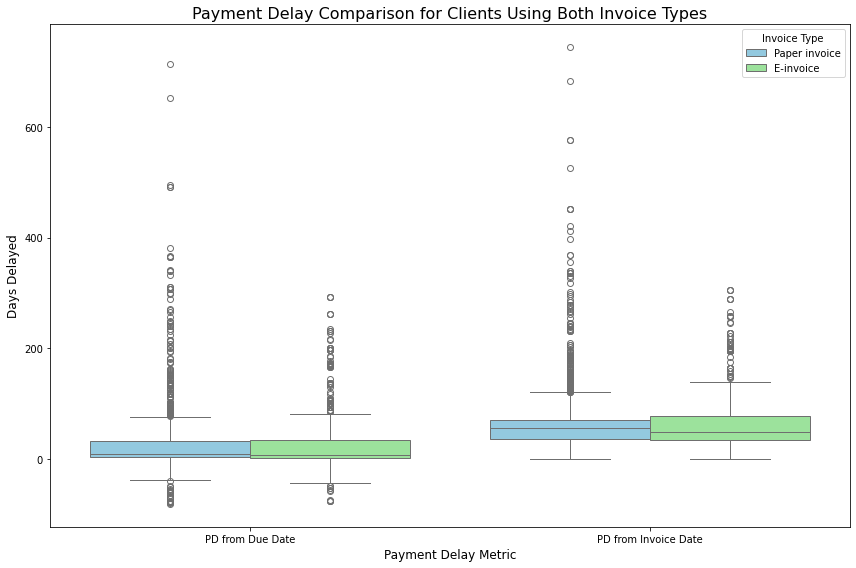

In [31]:
# --- Visualization (Box Plots) ---
print("\n--- Generating Visualization ---")

# "Melt" the DataFrame to make it easy to plot with seaborn
plot_df = switcher_df.melt(
    id_vars=['Customer', 'Paper / Electronic'], 
    value_vars=['PD_from_Due_Date', 'PD_from_Inv_Date'], 
    var_name='Delay_Type', 
    value_name='Days_Delayed'
)

# Rename for clearer plot labels
plot_df['Delay_Type'] = plot_df['Delay_Type'].replace({
    'PD_from_Due_Date': 'PD from Due Date',
    'PD_from_Inv_Date': 'PD from Invoice Date'
})

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=plot_df, 
    x='Delay_Type', 
    y='Days_Delayed', 
    hue='Paper / Electronic',
    palette={'Paper invoice': 'skyblue', 'E-invoice': 'lightgreen'}
)

plt.title('Payment Delay Comparison for Clients Using Both Invoice Types', fontsize=16)
plt.ylabel('Days Delayed', fontsize=12)
plt.xlabel('Payment Delay Metric', fontsize=12)
plt.legend(title='Invoice Type')
plt.tight_layout()

# Save the plot
plot_filename = 'payment_delay_comparison_boxplot.png'
plt.savefig(plot_filename)

print(f"Generated boxplot: '{plot_filename}'")

## Question 2

#### Is there a positive impact on disputes, pre versus post-enablement? Measured as follows:

- Fewer disputes (measured in both value and volume)
- Time to identify a dispute (Identification Time)
- Dispute Resolution Time (days between Dispute start date and settled date)

In [32]:
# We will use the 'switcher_df' created in the previous analysis,
# as it already contains the data for the 12 clients who used both invoice types.

print("--- Preparing Data for Dispute Analysis ---")

# 1. Create a copy to work on
dispute_df = switcher_df.copy()

# 2. Convert 'Inv tot amt' to numeric (remove commas first)
if dispute_df['Inv tot amt'].dtype == 'object':
    dispute_df['Inv tot amt'] = dispute_df['Inv tot amt'].str.replace(',', '', regex=False).astype(float)

# 3. Convert dispute-related date columns to datetime
# 'Inv date' is already datetime from the previous step.
dispute_date_cols = ['Invdisputedate', 'Startdate', 'Resdate']
for col in dispute_date_cols:
    dispute_df[col] = pd.to_datetime(dispute_df[col], dayfirst=True, errors='coerce')

# 4. Create the 'Is_Disputed' flag (True if Disputenumber is not null)
dispute_df['Is_Disputed'] = dispute_df['Disputenumber'].notnull()

# 5. Calculate new time-based metrics for disputed invoices
# Metric 3: Time to identify a dispute (Identification Time)
dispute_df['Identification_Time'] = (dispute_df['Invdisputedate'] - dispute_df['Inv date']).dt.days

# Metric 4: Dispute Resolution Time
# (Using 'Resdate' - 'Startdate' as it's the most logical for the dispute lifecycle)
dispute_df['Resolution_Time'] = (dispute_df['Resdate'] - dispute_df['Startdate']).dt.days

# 6. Display info to confirm new dtypes and columns
print("\n--- Processed Dispute Data Info ---")
dispute_df.info()

--- Preparing Data for Dispute Analysis ---

--- Processed Dispute Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 4450 entries, 0 to 4669
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Country              4450 non-null   object        
 1   Ctry code            4450 non-null   int64         
 2   Customer             4450 non-null   object        
 3   Boarding date        4450 non-null   object        
 4   Cust nbr             4450 non-null   int64         
 5   Inv nbr              4450 non-null   object        
 6   Inv date             4450 non-null   datetime64[ns]
 7   Due date             4450 non-null   datetime64[ns]
 8   Inv tot amt          4450 non-null   float64       
 9   Revtype              4450 non-null   object        
 10  Settled date         4450 non-null   datetime64[ns]
 11  PD_from_Due_Date     4450 non-null   int64         
 12  Status        

C:\Users\shrey\AppData\Local\Temp\ipykernel_4568\3457635478.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dispute_df[col] = pd.to_datetime(dispute_df[col], dayfirst=True, errors='coerce')


In [33]:
print("\n--- Analysis: Dispute Volume & Value ---")

# 1. Get TOTAL Volume and Value by invoice type
total_agg = dispute_df.groupby('Paper / Electronic').agg(
    Total_Volume=('Inv nbr', 'count'),
    Total_Value=('Inv tot amt', 'sum')
)

# 2. Get DISPUTED Volume and Value by invoice type
disputed_agg = dispute_df[dispute_df['Is_Disputed'] == True].groupby('Paper / Electronic').agg(
    Disputed_Volume=('Inv nbr', 'count'),
    Disputed_Value=('Inv tot amt', 'sum')
)

# 3. Combine the two dataframes
volume_value_summary = total_agg.join(disputed_agg)

# 4. Calculate Dispute Rates
volume_value_summary['Dispute_Rate_Volume'] = (volume_value_summary['Disputed_Volume'] / volume_value_summary['Total_Volume']) * 100
volume_value_summary['Dispute_Rate_Value'] = (volume_value_summary['Disputed_Value'] / volume_value_summary['Total_Value']) * 100

# 5. Format for readability
volume_value_summary['Total_Value'] = volume_value_summary['Total_Value'].map('{:,.2f}'.format)
volume_value_summary['Disputed_Value'] = volume_value_summary['Disputed_Value'].map('{:,.2f}'.format)
volume_value_summary['Dispute_Rate_Volume'] = volume_value_summary['Dispute_Rate_Volume'].map('{:.2f}%'.format)
volume_value_summary['Dispute_Rate_Value'] = volume_value_summary['Dispute_Rate_Value'].map('{:.2f}%'.format)


volume_value_summary


--- Analysis: Dispute Volume & Value ---


,Total_Volume,Total_Value,Disputed_Volume,Disputed_Value,Dispute_Rate_Volume,Dispute_Rate_Value
Paper / Electronic,,,,,,
E-invoice,975,"62,407,347.88",167,"1,268,273.40",17.13%,2.03%
Paper invoice,3475,"129,508,336.45",265,"4,282,102.60",7.63%,3.31%


In [34]:
print("\n--- Analysis: Time-based Dispute Metrics (Identification & Resolution) ---")

# 1. Filter for only the disputed invoices that have valid time calculations
time_metrics_df = dispute_df[
    (dispute_df['Is_Disputed'] == True) & 
    (dispute_df['Identification_Time'].notnull() | dispute_df['Resolution_Time'].notnull())
]

# 2. Group by invoice type and get mean and median for the two time metrics
time_summary = time_metrics_df.groupby('Paper / Electronic')[['Identification_Time', 'Resolution_Time']].agg(['mean', 'median', 'count'])

time_summary


--- Analysis: Time-based Dispute Metrics (Identification & Resolution) ---


Identification_Time              Resolution_Time         \
                                  mean median count            mean median   
Paper / Electronic                                                           
E-invoice                    67.838323   54.0   167       41.191358   42.0   
Paper invoice                51.871698   45.0   265       39.181132   17.0   

                          
                   count  
Paper / Electronic        
E-invoice            162  
Paper invoice        265


--- Generating Visualization for Dispute Timings ---
Generated boxplot: 'dispute_time_comparison_boxplot.png'


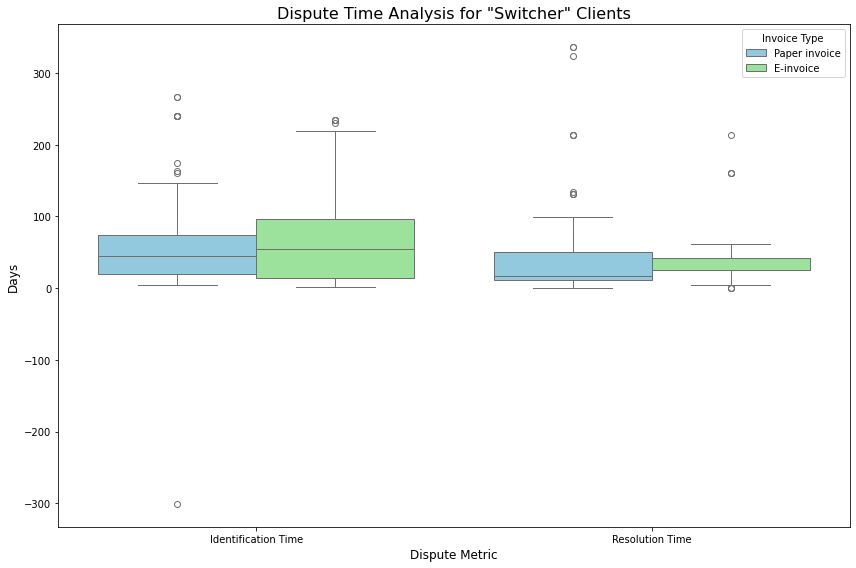

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating Visualization for Dispute Timings ---")

# 1. Use the 'time_metrics_df' from the previous cell
# 2. "Melt" the DataFrame to a long format for easier plotting
plot_time_df = time_metrics_df.melt(
    id_vars=['Customer', 'Paper / Electronic'], 
    value_vars=['Identification_Time', 'Resolution_Time'], 
    var_name='Metric_Type', 
    value_name='Days'
)

# 3. Rename for clearer plot labels
plot_time_df['Metric_Type'] = plot_time_df['Metric_Type'].replace({
    'Identification_Time': 'Identification Time',
    'Resolution_Time': 'Resolution Time'
})

# 4. Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=plot_time_df, 
    x='Metric_Type', 
    y='Days', 
    hue='Paper / Electronic',
    palette={'Paper invoice': 'skyblue', 'E-invoice': 'lightgreen'}
)

plt.title('Dispute Time Analysis for "Switcher" Clients', fontsize=16)
plt.ylabel('Days', fontsize=12)
plt.xlabel('Dispute Metric', fontsize=12)
plt.legend(title='Invoice Type')
plt.tight_layout()

# 5. Save the plot
plot_filename = 'dispute_time_comparison_boxplot.png'
plt.savefig(plot_filename)

print(f"Generated boxplot: '{plot_filename}'")

## Question 3

#### Are there any other notable correlations between electronic invoicing and revenue collection?

- Geography (Country)
- Client set (Industry)
- Brand(s) (per Brand column)

In [36]:
# We continue to use 'switcher_df' from the previous analysis

print("--- Checking Unique Values in 'switcher_df' ---")

print("\nUnique 'Country' values:")
print(switcher_df['Country'].unique())

print("\nUnique 'Revtype' values (as proxy for 'Brand'):")
print(switcher_df['Revtype'].unique())

print("\nNote: The dataset does not contain an 'Industry' or 'Brand' column.")
print("We will analyze by 'Country', 'Revtype', and 'Customer'.")

--- Checking Unique Values in 'switcher_df' ---

Unique 'Country' values:
['Spain' 'UK' 'Portugal']

Unique 'Revtype' values (as proxy for 'Brand'):
['TLA' 'MAN' 'GTS' 'DSW' 'LSE' 'RER' 'PIE' 'GBS' 'VAR' 'SWG' 'PON' 'PER'
 'PRE' 'LPF' 'PRI' 'REQ' 'OTC' 'NCU']

Note: The dataset does not contain an 'Industry' or 'Brand' column.
We will analyze by 'Country', 'Revtype', and 'Customer'.


In [37]:
print("--- Converting 'Inv tot amt' to numeric in switcher_df ---")

# The 'Inv tot amt' column still has commas and is an 'object' type.
# We must convert it to numeric before we can calculate a median.
# We use .loc to modify the DataFrame directly and avoid a SettingWithCopyWarning
if switcher_df['Inv tot amt'].dtype == 'object':
    switcher_df.loc[:, 'Inv tot amt'] = switcher_df['Inv tot amt'].str.replace(',', '', regex=False).astype(float)
    print("Conversion complete.")
else:
    print("'Inv tot amt' is already numeric.")

print(switcher_df[['Inv tot amt']].info())

--- Converting 'Inv tot amt' to numeric in switcher_df ---
Conversion complete.
<class 'pandas.core.frame.DataFrame'>
Index: 4450 entries, 0 to 4669
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Inv tot amt  4450 non-null   object
dtypes: object(1)
memory usage: 69.5+ KB
None


In [38]:
print("\n--- Analysis: Revenue Collection by Country ---")

# Group by Country and Invoice Type
country_agg = switcher_df.groupby(['Country', 'Paper / Electronic']).agg(
    Median_PD_Due=('PD_from_Due_Date', 'median'),
    Mean_PD_Due=('PD_from_Due_Date', 'mean'),
    Median_PD_Inv=('PD_from_Inv_Date', 'median'),
    Mean_PD_Inv=('PD_from_Inv_Date', 'mean'),
    Median_Inv_Amt=('Inv tot amt', 'median'),
    Total_Inv_Value=('Inv tot amt', 'sum'),
    Count=('Inv nbr', 'count')
)

country_agg


--- Analysis: Revenue Collection by Country ---


Median_PD_Due  Mean_PD_Due  Median_PD_Inv  \
Country  Paper / Electronic                                              
Portugal E-invoice                     1.0     9.168182           63.0   
         Paper invoice                 8.0    23.773013           67.0   
Spain    E-invoice                     5.0    21.002016           35.5   
         Paper invoice                11.0    23.214139           43.0   
UK       E-invoice                    26.0    52.795367           53.0   
         Paper invoice                10.0    16.176367           40.0   

                             Mean_PD_Inv Median_Inv_Amt Total_Inv_Value  Count  
Country  Paper / Electronic                                                     
Portugal E-invoice             70.727273       16802.76     24252554.18    220  
         Paper invoice         75.177824         813.12     25201376.28    956  
Spain    E-invoice             51.806452        1028.78     29542946.34    496  
         Paper invoice         57.640881         1058.7     89166791.73   1952  
UK       E-invoice             82.749035        1528.11      8611847.36    259  
         Paper invoice         51.500882         831.09     15140168.44    567

In [39]:
print("\n--- Analysis: Revenue Collection by Revtype (Brand Proxy) ---")

# Group by Revtype and Invoice Type
revtype_agg = switcher_df.groupby(['Revtype', 'Paper / Electronic']).agg(
    Median_PD_Due=('PD_from_Due_Date', 'median'),
    Mean_PD_Due=('PD_from_Due_Date', 'mean'),
    Median_PD_Inv=('PD_from_Inv_Date', 'median'),
    Mean_PD_Inv=('PD_from_Inv_Date', 'mean'),
    Median_Inv_Amt=('Inv tot amt', 'median'),
    Total_Inv_Value=('Inv tot amt', 'sum'),
    Count=('Inv nbr', 'count')
)

revtype_agg


--- Analysis: Revenue Collection by Revtype (Brand Proxy) ---


Median_PD_Due  Mean_PD_Due  Median_PD_Inv  \
Revtype Paper / Electronic                                              
DSW     E-invoice                    74.0    65.500000           74.0   
        Paper invoice                59.0    46.769231           66.0   
GBS     E-invoice                    -8.0    -7.305970           65.0   
        Paper invoice                 9.5    24.355670           79.5   
GTS     E-invoice                     4.0     6.255605           34.0   
        Paper invoice                 4.0     8.196765           35.0   
LPF     Paper invoice               168.0   166.000000          198.0   
LSE     E-invoice                     3.0     3.000000           33.0   
        Paper invoice                12.5    16.300000           42.5   
MAN     E-invoice                    10.0    11.066667           60.0   
        Paper invoice                19.0    32.073171           67.0   
NCU     E-invoice                    16.0    17.642857           46.0   
        Paper invoice                20.0    15.500000           50.0   
OTC     E-invoice                     6.0   -16.000000           66.0   
PER     E-invoice                    11.0    11.000000           41.0   
        Paper invoice               -18.0    33.647059           12.0   
PIE     Paper invoice                19.0    26.961538           49.0   
PON     Paper invoice                64.5    64.500000          104.5   
PRE     E-invoice                     4.5     7.500000           34.0   
        Paper invoice                 2.0    26.800000           32.0   
PRI     Paper invoice               -11.0    -9.000000           14.0   
REQ     Paper invoice                -9.0     4.333333           21.0   
RER     E-invoice                   -13.0    -4.777778           26.0   
        Paper invoice                27.5    30.327586           60.0   
SWG     E-invoice                     3.0    18.000000           36.5   
        Paper invoice                11.5    42.529412           86.5   
TLA     E-invoice                    23.0    48.015936           50.0   
        Paper invoice                13.0    25.007096           62.0   
VAR     E-invoice                     6.0     9.642857           58.5   
        Paper invoice                10.0    19.942857           70.0   

                            Mean_PD_Inv Median_Inv_Amt Total_Inv_Value  Count  
Revtype Paper / Electronic                                                     
DSW     E-invoice             65.500000       24630.41       736761.17      8  
        Paper invoice         60.615385       10122.67      1050815.95     13  
GBS     E-invoice             71.462687       17229.98      3549446.57    134  
        Paper invoice         89.329897      38859.995      9648990.55    194  
GTS     E-invoice             40.210762       50379.97     29513469.31    223  
        Paper invoice         46.154987       27774.23     82995424.46    742  
LPF     Paper invoice        196.000000       1591.485        10486.33      4  
LSE     E-invoice             33.000000         3049.2          3049.2      1  
        Paper invoice         46.300000        2191.83        23832.41     10  
MAN     E-invoice             53.266667        8163.63      4094355.43     45  
        Paper invoice         74.297561        5708.57      7243413.58    205  
NCU     E-invoice             47.642857      423538.05      7491362.43     14  
        Paper invoice         45.500000      382844.15      3286619.97      8  
OTC     E-invoice             44.000000       216554.7      1996236.22      5  
PER     E-invoice             41.000000        9491.03        18982.06      2  
        Paper invoice         63.647059        1780.52        66591.61     17  
PIE     Paper invoice         55.807692         108.46         3520.49     26  
PON     Paper invoice        104.500000       165583.5        331167.0      2  
PRE     E-invoice             37.000000       50217.97       200871.88      4  
        Pap

In [40]:
print("\n--- Analysis: Revenue Collection by Customer (Client Set Proxy) ---")

# Group by Customer and Invoice Type
customer_agg = switcher_df.groupby(['Customer', 'Paper / Electronic']).agg(
    Median_PD_Due=('PD_from_Due_Date', 'median'),
    Mean_PD_Due=('PD_from_Due_Date', 'mean'),
    Median_PD_Inv=('PD_from_Inv_Date', 'median'),
    Mean_PD_Inv=('PD_from_Inv_Date', 'mean'),
    Median_Inv_Amt=('Inv tot amt', 'median'),
    Total_Inv_Value=('Inv tot amt', 'sum'),
    Count=('Inv nbr', 'count')
)

# Sort to keep clients together for readability
customer_agg.sort_index()


--- Analysis: Revenue Collection by Customer (Client Set Proxy) ---


Median_PD_Due  Mean_PD_Due  \
Customer               Paper / Electronic                               
Ayuntamiento de Alzira E-invoice                     1.0     6.368421   
                       Paper invoice                41.0    45.180328   
BMS                    E-invoice                     4.5     9.350000   
                       Paper invoice                 6.0    10.029126   
CECA                   E-invoice                     4.0     6.408451   
                       Paper invoice                 4.0    10.700000   
CRTVE                  E-invoice                    18.0    25.588235   
                       Paper invoice                10.0    20.097744   
Colgate                E-invoice                    10.0    32.493776   
                       Paper invoice                15.0    28.414695   
GM                     E-invoice                    24.0    30.200000   
                       Paper invoice                33.0    38.727273   
HP                     E-invoice                     0.5    -4.888889   
                       Paper invoice                19.0    13.609756   
Iberia                 E-invoice                    -2.0    -0.359375   
                       Paper invoice                 7.0    13.098039   
Kelloggs               E-invoice                    48.0    70.241026   
                       Paper invoice                10.0    17.314010   
Nestle                 E-invoice                    10.0    14.761905   
                       Paper invoice                17.0    31.591837   
Repsol                 E-invoice                    -8.0    -3.551724   
                       Paper invoice                 4.0    42.432000   
Unilever               E-invoice                    32.0    41.148148   
                       Paper invoice                 8.0    18.682749   

                                           Median_PD_Inv  Mean_PD_Inv  \
Customer               Paper / Electronic                               
Ayuntamiento de Alzira E-invoice                    30.0    33.736842   
                       Paper invoice                95.0   100.278689   
BMS                    E-invoice                    34.5    39.350000   
                       Paper invoice                36.0    39.592233   
CECA                   E-invoice                    34.0    35.133803   
                       Paper invoice                34.0    40.420833   
CRTVE                  E-invoice                    70.0    69.745098   
                       Paper invoice                70.0    80.466165   
Colgate                E-invoice                    37.0    60.244813   
                       Paper invoice                43.0    57.083437   
GM                     E-invoice                    84.0    84.200000   
                       Paper invoice                63.5    69.914141   
HP                     E-invoice                    49.0    43.444444   
                       Paper invoice                49.0    44.707317   
Iberia                 E-invoice                    32.0    36.312500   
                       Paper invoice                69.0    68.333333   
Kelloggs               E-invoice                    77.0    97.989744   
                       Paper invoice                38.0    45.280193   
Nestle                 E-invoice                    64.0    58.142857   
                       Paper invoice                67.0    70.129252   
Repsol                 E-invoice                    63.0    70.096552   
                       Paper invoice                89.0   113.000000   
Unilever               E-invoice                    63.0    77.314815   
                       Paper invoice                66.0    69.350877   

                                          Median_Inv_Amt Total_Inv_Value  \
Customer               Paper / Electronic                                  
Ayuntamiento de Alzira E-invoice                 2860.26        91157.44   
                 


--- Generating Visualizations for Correlations ---
Generated grouped bar plot: 'correlations_grouped_barplot.png'


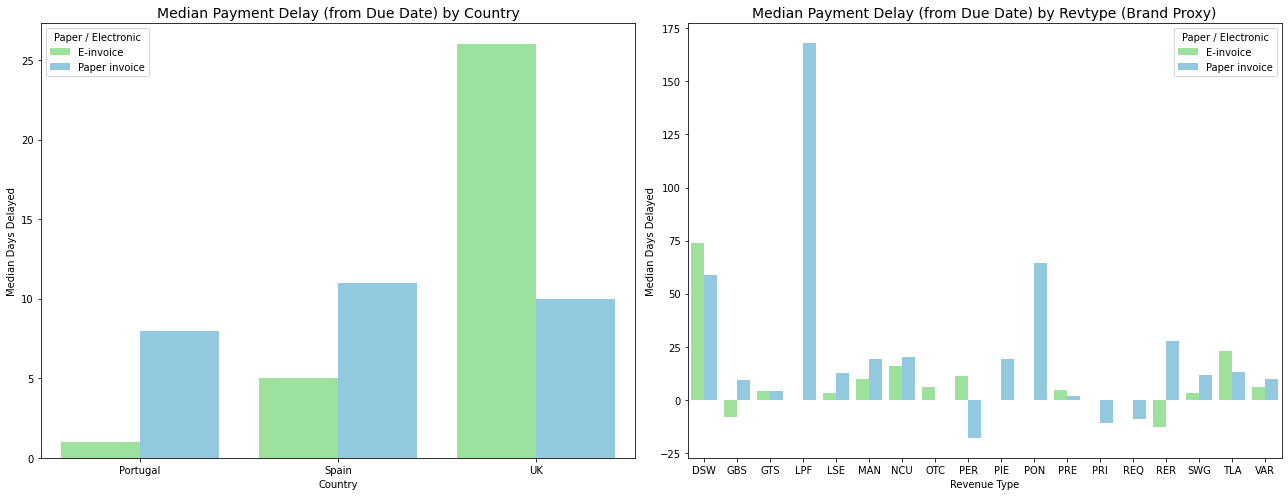

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating Visualizations for Correlations ---")

# 1. Prepare data for plotting (Median PD from Due Date)
country_plot_df = country_agg.reset_index()
revtype_plot_df = revtype_agg.reset_index()

# 2. Create Figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: By Country
sns.barplot(
    data=country_plot_df,
    x='Country',
    y='Median_PD_Due',
    hue='Paper / Electronic',
    palette={'Paper invoice': 'skyblue', 'E-invoice': 'lightgreen'},
    ax=ax1
)
ax1.set_title('Median Payment Delay (from Due Date) by Country', fontsize=14)
ax1.set_ylabel('Median Days Delayed')
ax1.set_xlabel('Country')

# Plot 2: By Revtype
sns.barplot(
    data=revtype_plot_df,
    x='Revtype',
    y='Median_PD_Due',
    hue='Paper / Electronic',
    palette={'Paper invoice': 'skyblue', 'E-invoice': 'lightgreen'},
    ax=ax2
)
ax2.set_title('Median Payment Delay (from Due Date) by Revtype (Brand Proxy)', fontsize=14)
ax2.set_ylabel('Median Days Delayed')
ax2.set_xlabel('Revenue Type')

plt.tight_layout()

# Save the plot
plot_filename = 'correlations_grouped_barplot.png'
plt.savefig(plot_filename)

print(f"Generated grouped bar plot: '{plot_filename}'")